In [1]:
# ! kaggle --version

# ! kaggle competitions download -c dsi-us-8-project-2-regression-challenge

# ! kaggle competitions submissions -c dsi-us-8-project-2-regression-challenge

# ! kaggle competitions submit [-h] -c dsi-us-8-project-2-regression-challenge -f FILE -m MESSAGE


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
#; sns.set(style="ticks", color_codes=True)
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
data_dir = "./datasets/"

print(os.listdir(data_dir))

['cars_train', 'test.csv', 'sample_sub_reg.csv', 'train.csv']


In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')

In [5]:
# check the size of each data set
print(f'train len {len(train_df)} | test len {len(test_df)}')
# check out the training data
display(train_df.head(5))
# check out the testing data
display(test_df.head(5))

train len 2051 | test len 879


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


Correlation matrix (heatmap style)

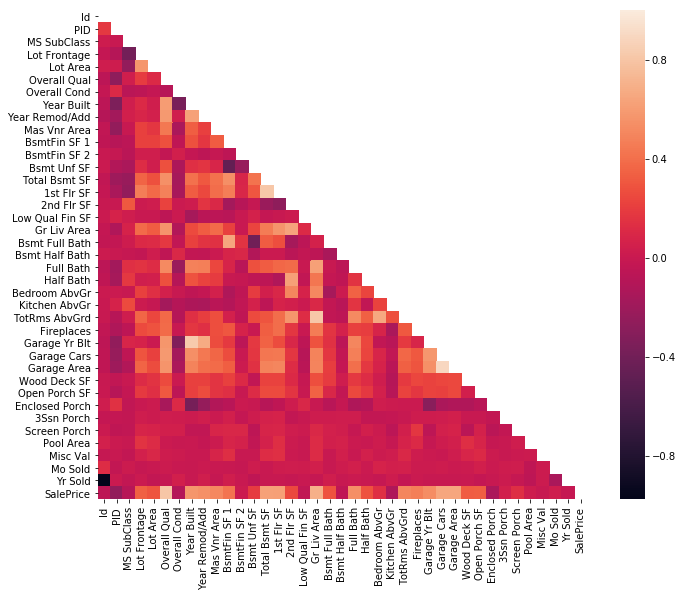

In [6]:
# correlation matrix
corrmat = train_df.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, mask=mask, square=True);

In [35]:
# get correlation between each IV and our DV
corr_vars = corrmat.sort_values(["SalePrice"], ascending = False)["SalePrice"]
print(corr_vars)
most_corr_vars = corr_vars.index.values.tolist()

SalePrice          1.000000
Overall Qual       0.800207
Gr Liv Area        0.697038
Garage Area        0.650270
Garage Cars        0.648220
Total Bsmt SF      0.628925
1st Flr SF         0.618486
Year Built         0.571849
Year Remod/Add     0.550370
Full Bath          0.537969
Garage Yr Blt      0.533922
Mas Vnr Area       0.512230
TotRms AbvGrd      0.504014
Fireplaces         0.471093
BsmtFin SF 1       0.423519
Lot Frontage       0.341842
Open Porch SF      0.333476
Wood Deck SF       0.326490
Lot Area           0.296566
Bsmt Full Bath     0.283662
Half Bath          0.283001
2nd Flr SF         0.248452
Bsmt Unf SF        0.190210
Bedroom AbvGr      0.137067
Screen Porch       0.134581
3Ssn Porch         0.048732
Mo Sold            0.032735
Pool Area          0.023106
BsmtFin SF 2       0.016255
Misc Val          -0.007375
Yr Sold           -0.015203
Low Qual Fin SF   -0.041594
Bsmt Half Bath    -0.045328
Id                -0.051398
MS SubClass       -0.087335
Overall Cond      -0

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.

Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

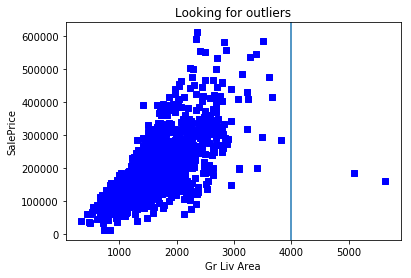

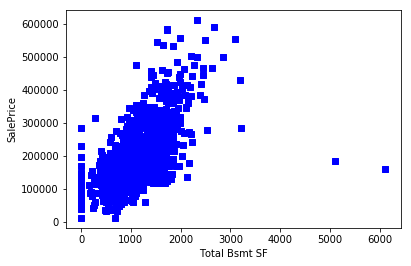

In [7]:
## look for outliers
# scatter plot gr liv area/saleprice
plt.scatter(train_df["Gr Liv Area"], train_df["SalePrice"], c = "blue", marker = "s")
plt.axvline(x=4000)
plt.title("Looking for outliers")
plt.xlabel("Gr Liv Area")
plt.ylabel("SalePrice")
plt.show()

# scatter plot total bsmt sf/saleprice
plt.scatter(train_df["Total Bsmt SF"], train_df["SalePrice"], c = "blue", marker = "s")
plt.xlabel("Total Bsmt SF")
plt.ylabel("SalePrice")
plt.show()

In [8]:
# chuck out outliers
train_df = train_df[train_df["Gr Liv Area"] < 4000]

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [9]:
## log transform the target for official scoring
# train_df.SalePrice = np.log1p(train_df.SalePrice)

In [10]:
# define variables
y_train = train_df['SalePrice']
X_train = train_df.loc[:, train_df.columns != 'SalePrice']
X_test = test_df

test_rows, test_cols = X_test.shape
train_rows, train_cols = X_train.shape
print(test_cols, train_cols)
# column number should agree

80 80


In [11]:
def df_clean_scale_dummy(df_list, scaler):
    """ 
    Prep a DataFrame like it ain't no thang.
    - First it pairs
    - Then it cleans
    - Then it scales
    - Then it dummies
    Usage: scaled_df = df_clean_scale_dummy([X_train, X_test], scaler)
    """
    # get shape for later on
    train_rows, _ = df_list[0].shape
    
    # concatenate df's
    df = pd.concat(df_list)
    
    # replace nans with zeros
    df.fillna(0, inplace=True)
    
    # # scale selected columns
    # scale_cols = ['Lot Frontage', 'Lot Area', 'Gr Liv Area', 'Garage Area', 'Pool Area']
    # df = pd.DataFrame(scaler.fit_transform(df.values),
    #                 columns=df.columns,
    #                 index=df.index)
    
    # dummy categorical columns
    df = pd.get_dummies(df, drop_first=True)
    
    # split into original df's
    X_train = df.iloc[0:train_rows,:]
    X_test = df.iloc[train_rows:,:]
    
    return [X_train, X_test]
      
# select scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

[X_train_clean, X_test_clean] = df_clean_scale_dummy([X_train, X_test], scaler)

In [33]:
col_space

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 138, 142, 146, 150, 154,
       158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 207,
       211, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259,
       263, 267, 272])

Number of columns: 272


/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/anaconda3/envs/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


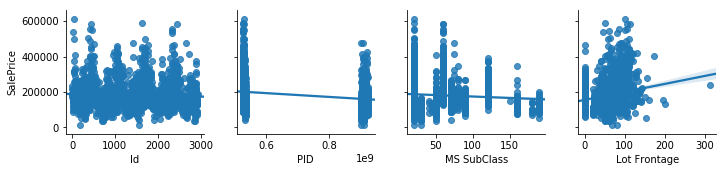

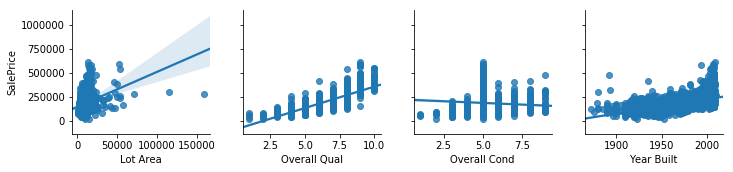

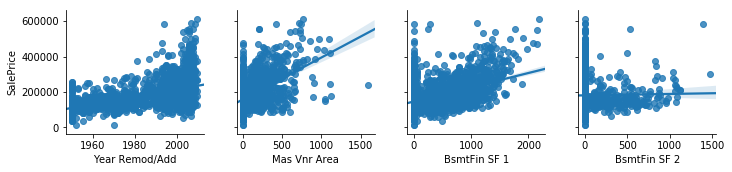

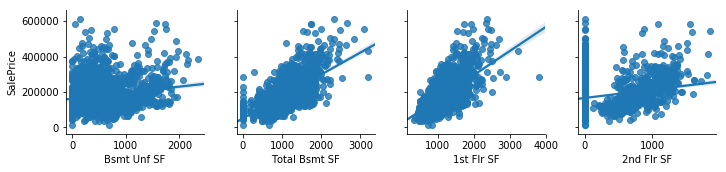

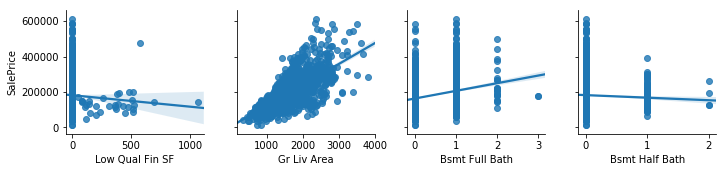

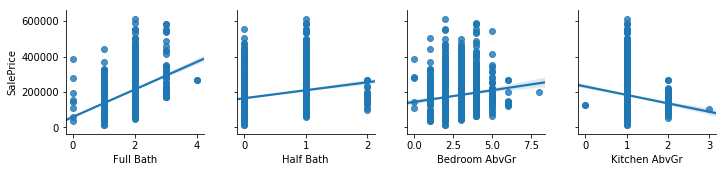

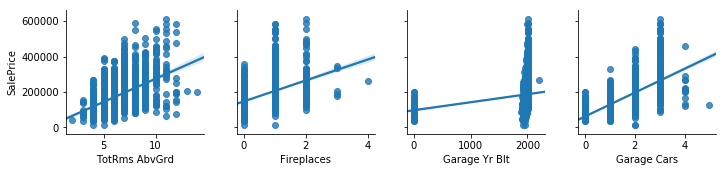

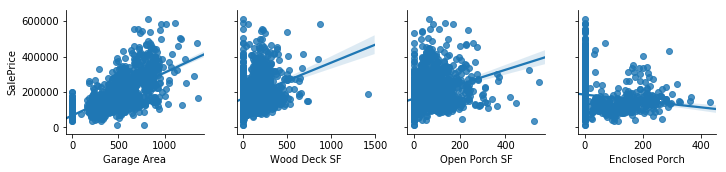

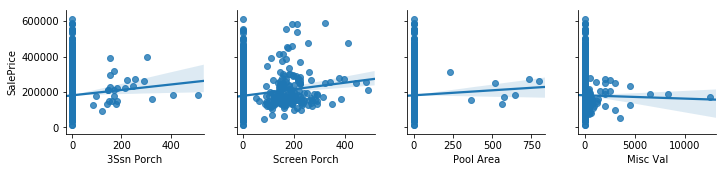

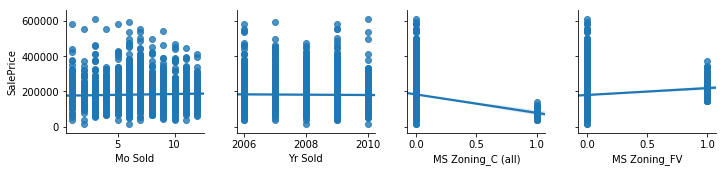

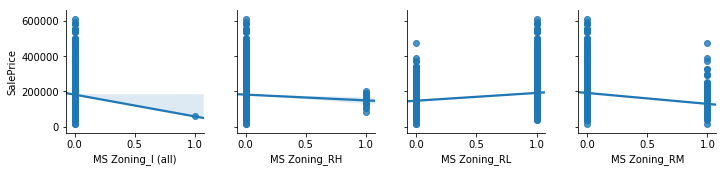

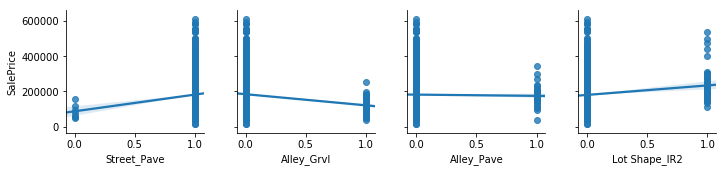

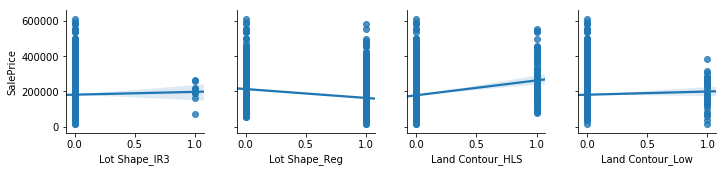

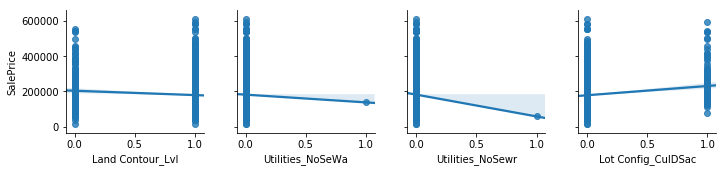

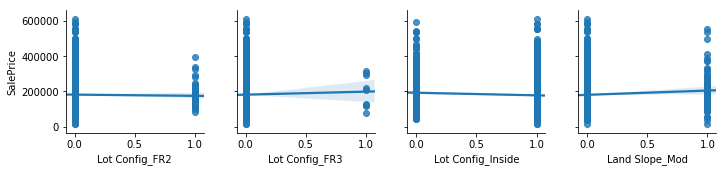

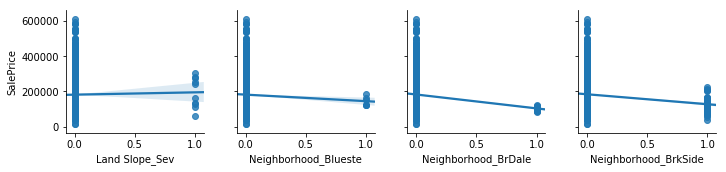

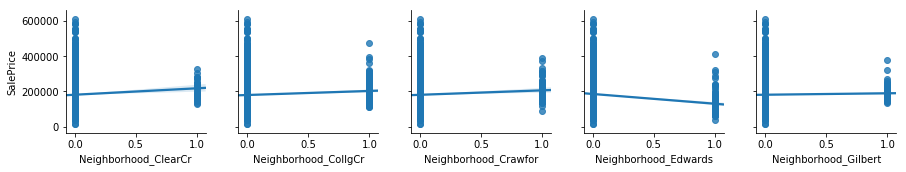

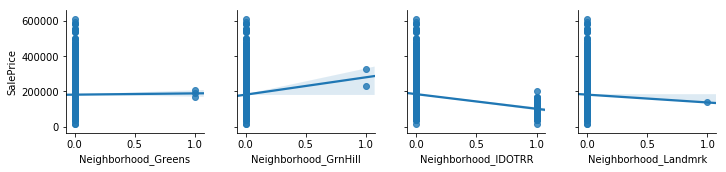

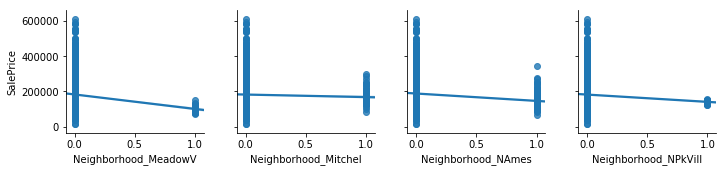

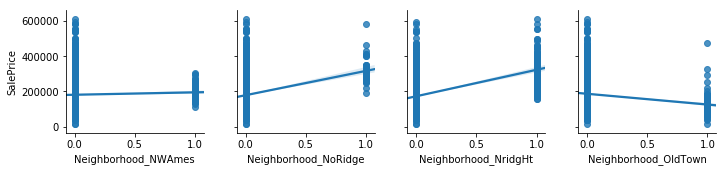

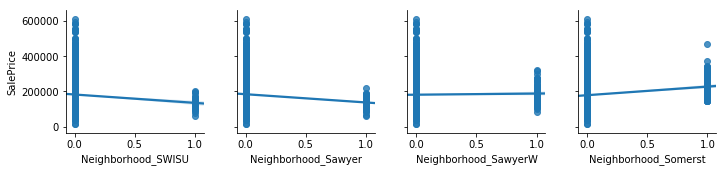

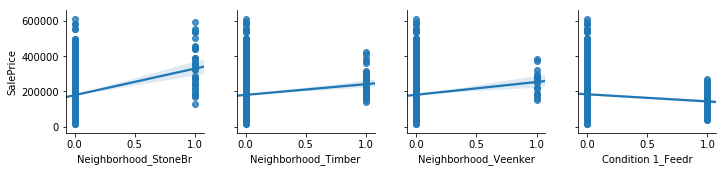

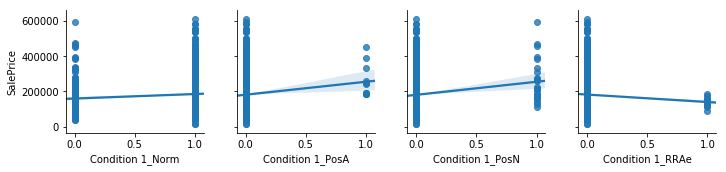

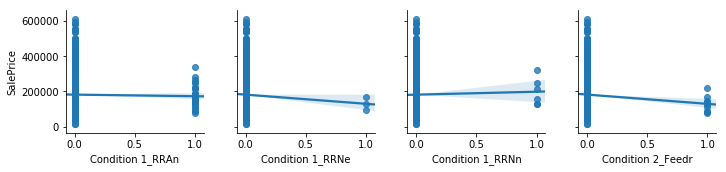

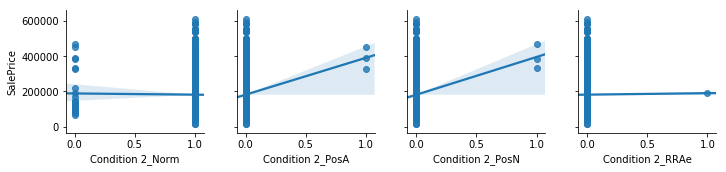

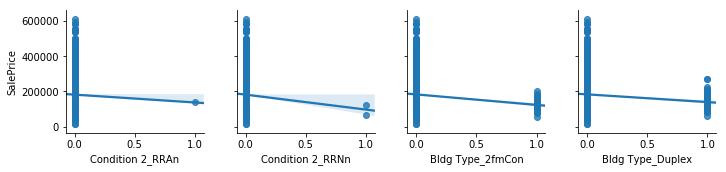

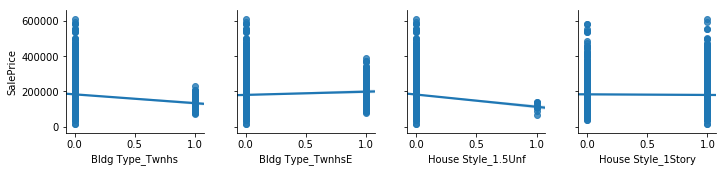

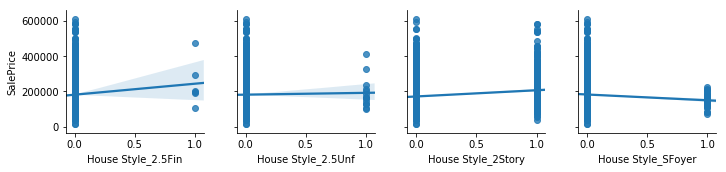

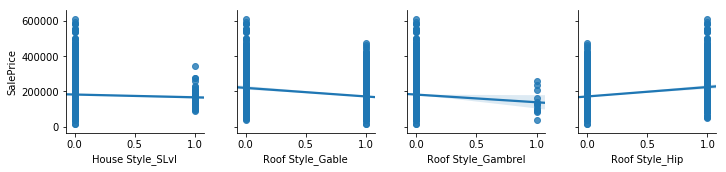

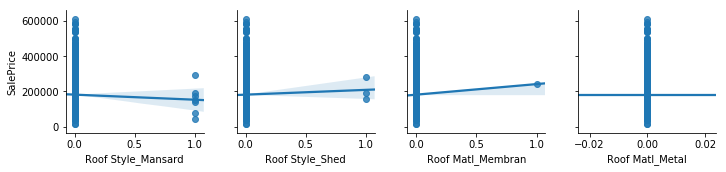

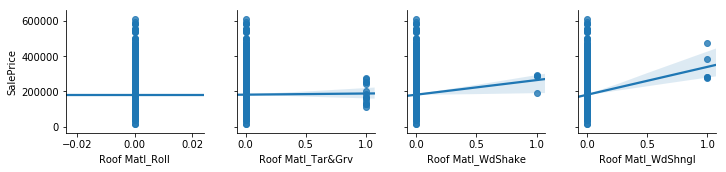

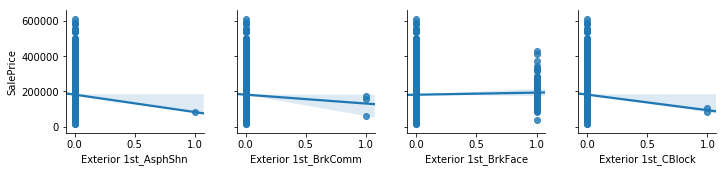

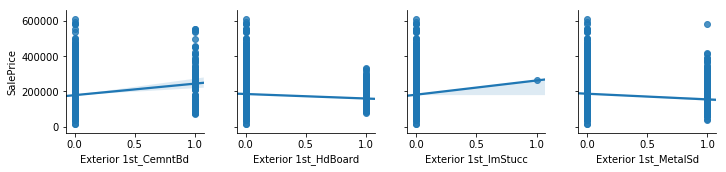

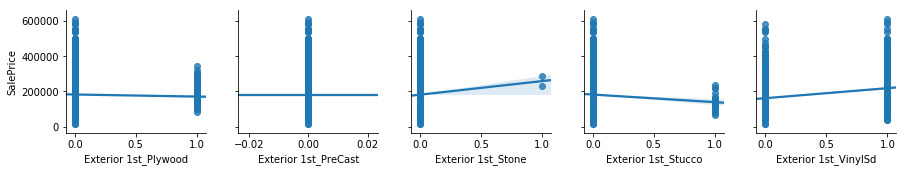

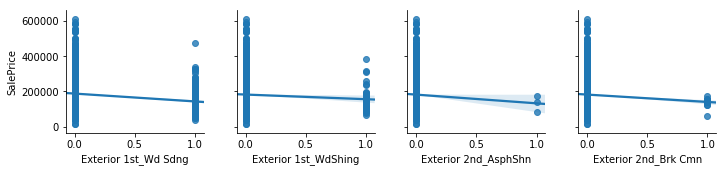

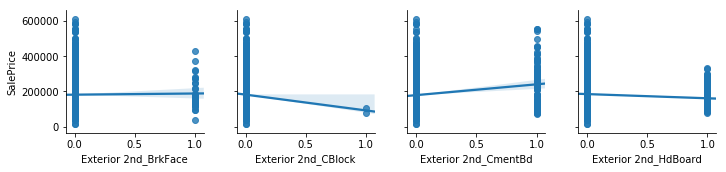

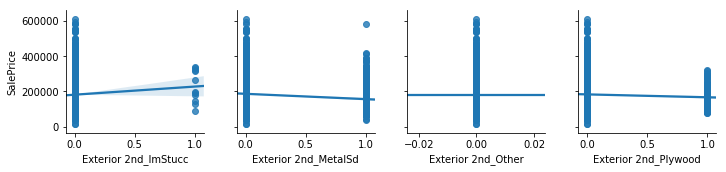

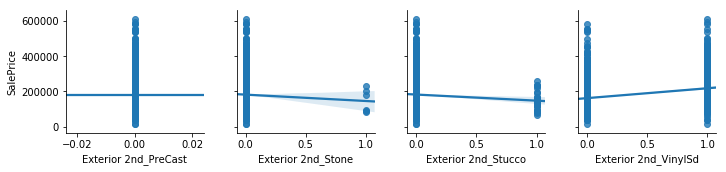

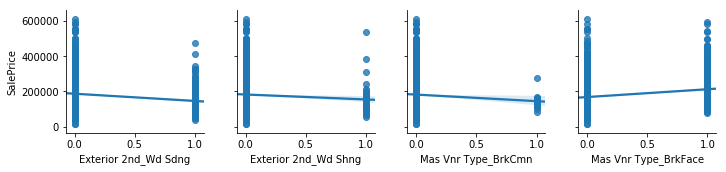

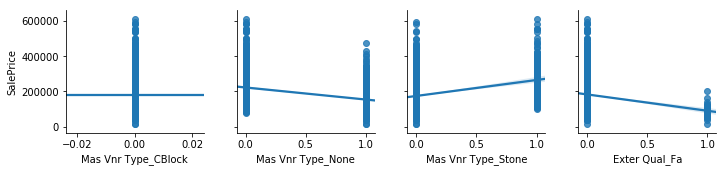

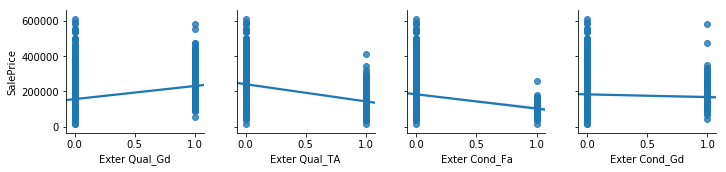

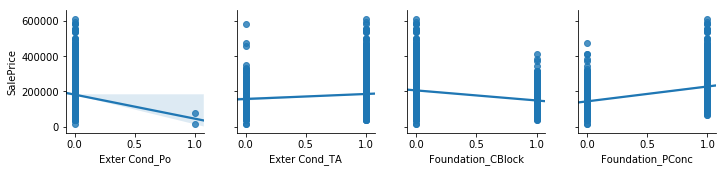

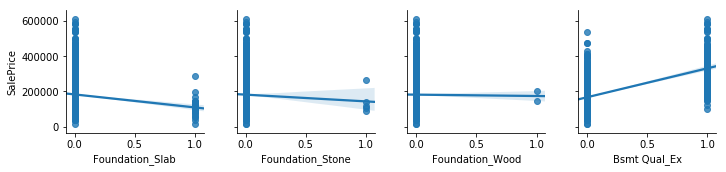

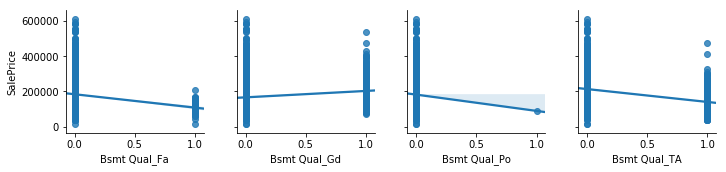

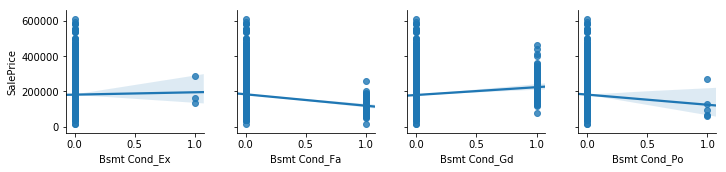

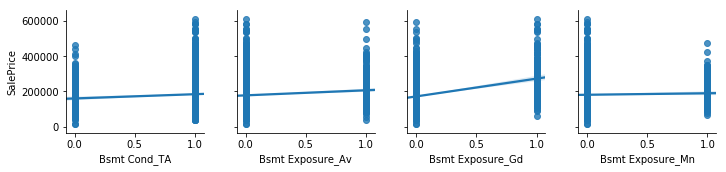

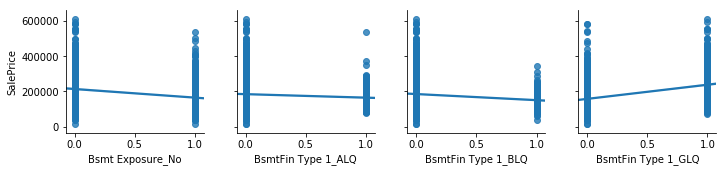

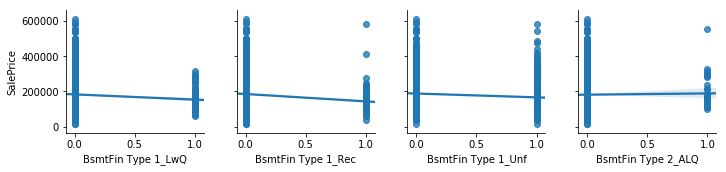

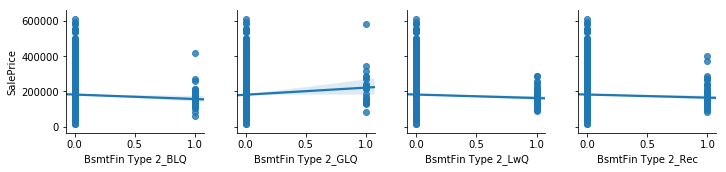

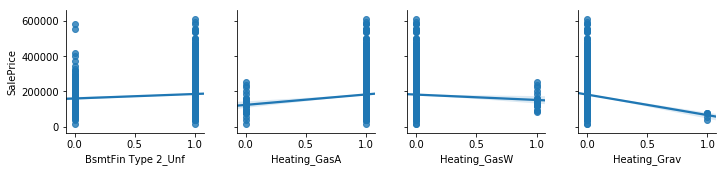

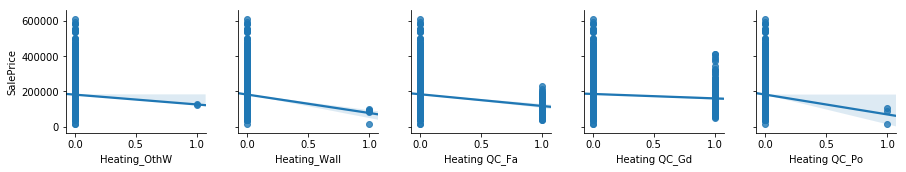

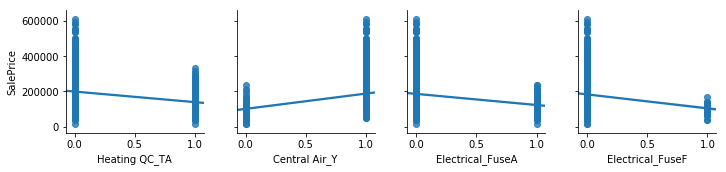

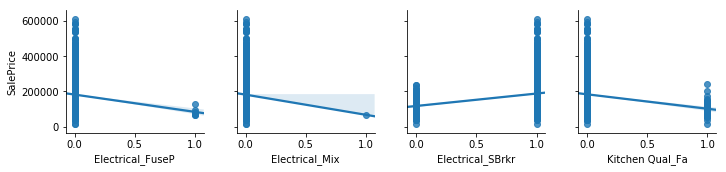

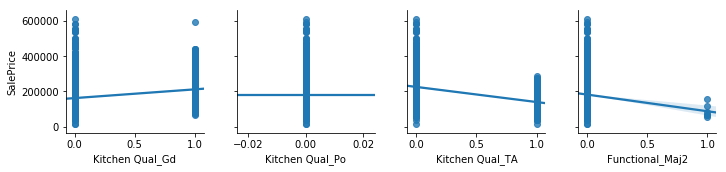

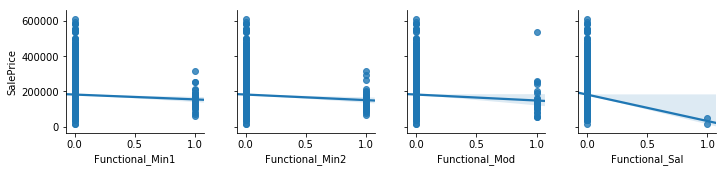

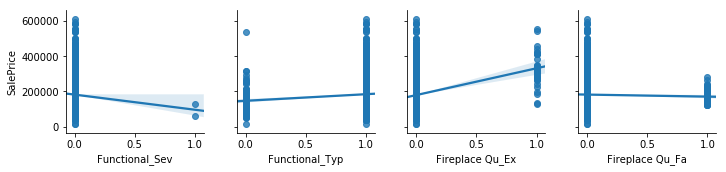

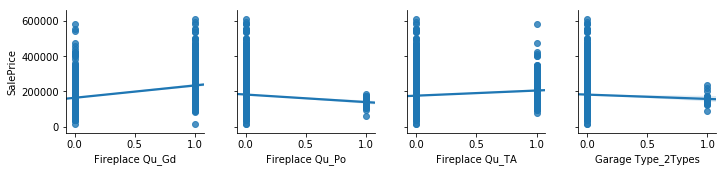

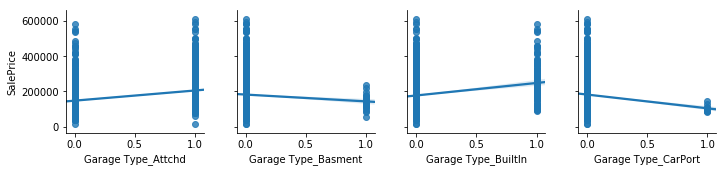

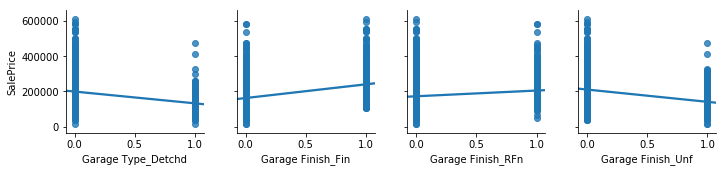

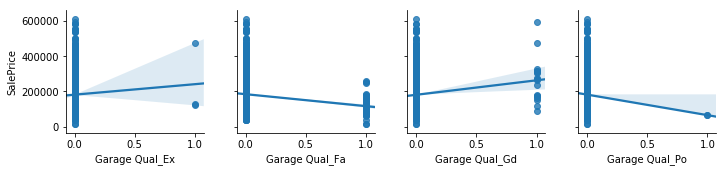

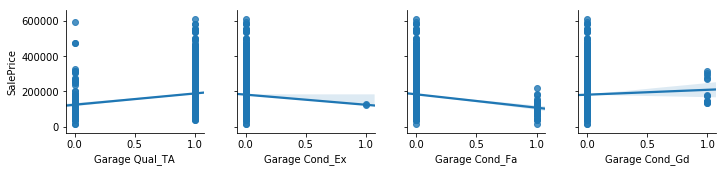

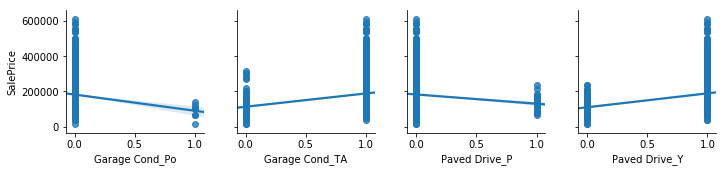

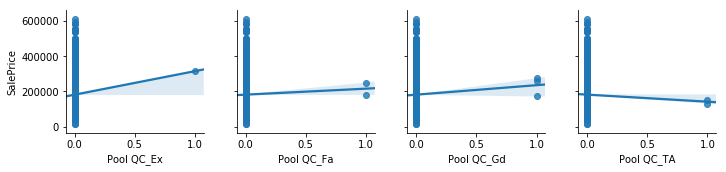

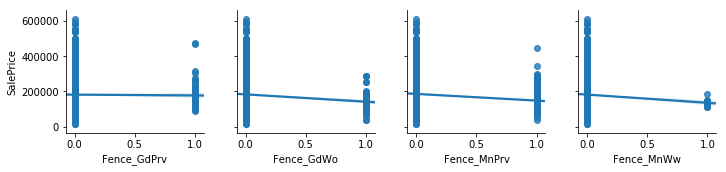

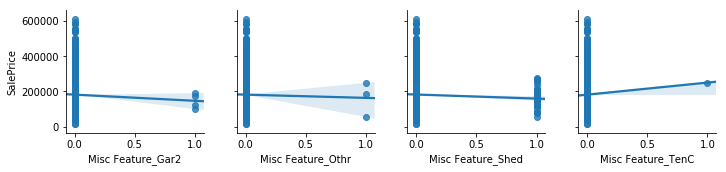

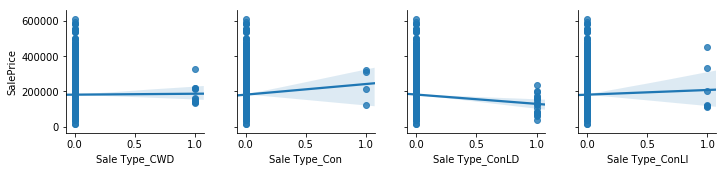

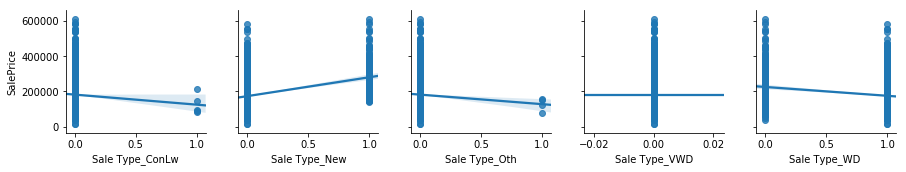

In [32]:
n = 4
total_cols = len(X_train_clean.columns)
print(f"Number of columns: {total_cols}")

# break down columns into start:stop points of length n
col_space = np.linspace(0,total_cols,total_cols/n).astype('int')

# loop through start:stop points
for i in range(len(col_space)-1):
    g = sns.pairplot(
                data=pd.concat([X_train_clean, y_train], axis=1), 
                y_vars=['SalePrice'],
                x_vars=X_train_clean.columns[col_space[i]:col_space[i+1]],
                kind="reg",
                    )

In [13]:
def df_drop(df_list, selected_columns):
    """ 
    Drop selected columns from DataFrame.
    - First it drops selected columns.
    - Then it finds more columns to drop (based on number of values).
    Usage: scaled_df = df_drop([X_train, X_test], ['column1', 'column3'])
    """
    # concatenate df's
    df = pd.concat(df_list)
    
    # drop selected columns
    df = df.drop(columns=selected_columns)
    
    # drop columns with less than n positive values
    n = 5
    print(f"Dropping columns ({sum(df.sum()<n)} total): {df.columns[df.sum()<n]}")
    df = df.loc[:,df.sum()>n]
              
    # split into original df's
    X_train = df.iloc[0:train_rows,:]
    X_test = df.iloc[train_rows:,:]
    
    return [X_train, X_test]
      
drop_list = ['PID', 'Lot Area', '2nd Flr SF', 'Low Qual Fin SF', 'BsmtFin SF 2']

[X_train_trimmed, X_test_trimmed] = df_drop([X_train_clean, X_test_clean], drop_list)

Dropping columns (41 total): Index(['MS Zoning_I (all)', 'Utilities_NoSeWa', 'Utilities_NoSewr',
       'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Condition 2_PosA',
       'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn',
       'Condition 2_RRNn', 'Roof Matl_Membran', 'Roof Matl_Metal',
       'Roof Matl_Roll', 'Exterior 1st_AsphShn', 'Exterior 1st_CBlock',
       'Exterior 1st_ImStucc', 'Exterior 1st_PreCast', 'Exterior 1st_Stone',
       'Exterior 2nd_AsphShn', 'Exterior 2nd_CBlock', 'Exterior 2nd_Other',
       'Exterior 2nd_PreCast', 'Mas Vnr Type_CBlock', 'Exter Cond_Po',
       'Bsmt Qual_Po', 'Bsmt Cond_Ex', 'Heating_OthW', 'Heating QC_Po',
       'Electrical_Mix', 'Kitchen Qual_Po', 'Functional_Sal', 'Functional_Sev',
       'Garage Qual_Ex', 'Garage Cond_Ex', 'Pool QC_Ex', 'Pool QC_Fa',
       'Pool QC_Gd', 'Pool QC_TA', 'Misc Feature_Othr', 'Misc Feature_TenC',
       'Sale Type_VWD'],
      dtype='object')


In [14]:
X_cat = pd.concat([X_train_trimmed, X_test_trimmed])
# print names of columns containing NaNs
X_cat.columns[X_cat.isnull().any().values]

Index([], dtype='object')

In [15]:
print(X_test_trimmed.shape, X_train_trimmed.shape, y_train.shape)

(879, 220) (2049, 220) (2049,)


In [16]:
# double check that everything worked out like we thought
display(pd.get_dummies(X_test, drop_first=True).head(1))
display(X_test_trimmed.head(1))
# (these should be the same)

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Misc Feature_Shed,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD
0,2658,902301120,190,69.0,9142,6,8,1910,1950,0.0,...,0,0,0,0,0,0,0,0,0,1


,Id,MS SubClass,Lot Frontage,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,...,Fence_MnPrv,Fence_MnWw,Misc Feature_Shed,Sale Type_CWD,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,2658,190,69.0,6,8,1910,1950,0.0,0.0,1020.0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets (k-times)
scores = cross_val_score(regr, X_train_trimmed, y_train, cv=5, scoring='neg_mean_squared_error')

# Measure MSE for training data
print("Mean MSE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 1.96))
print(f"MSE scores: {scores}")

Mean MSE: 566868815.67 (+/- 134699489.90)
MSE scores: [-6.32572062e+08 -4.71591885e+08 -4.95712196e+08 -6.23711892e+08
 -6.10756043e+08]


In [40]:
# Train the model using the training sets
regr.fit(X_train_trimmed, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test_trimmed)

In [50]:
# generate submission DataFrame
submission_pd = pd.DataFrame(X_test_trimmed.Id)
submission_pd['SalePrice'] = y_pred
submission_pd = submission_pd.sort_values(by=['Id'], ascending=True)
submission_pd.head()

,Id,SalePrice
704,2,121209.845273
706,4,283183.828441
120,6,197452.428836
312,7,223057.810974
401,17,200685.381032


In [20]:
# save df to csv file
submission_pd.to_csv('submission.csv', index=False)